In [ ]:
!pip install -q timm scikit-learn matplotlib seaborn tensorboard


In [ ]:
import os
import time
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

import timm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total - trainable
    return total, trainable, non_trainable

def model_size_mb(model, path="/tmp/tmp_model.pth"):
    torch.save(model.state_dict(), path)
    size = os.path.getsize(path) / 1e6
    os.remove(path)
    return size

def plot_history(history, title=""):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], marker='o')
    plt.title(title + " Train Loss")

    plt.subplot(1,2,2)
    plt.plot(history["test_acc"], marker='o')
    plt.title(title + " Test Accuracy")
    plt.show()


Device: cuda


In [ ]:
BATCH_SIZE = 8
EPOCHS = 5
LR = 1e-4

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_tf_vit = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_tf_vit = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_tf_swin = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_tf_swin = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_set_vit = CIFAR10("./data", train=True, download=True, transform=train_tf_vit)
test_set_vit  = CIFAR10("./data", train=False, download=True, transform=test_tf_vit)

train_loader_vit = DataLoader(train_set_vit, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_vit  = DataLoader(test_set_vit,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train_set_swin = CIFAR10("./data", train=True, download=False, transform=train_tf_swin)
test_set_swin  = CIFAR10("./data", train=False, download=False, transform=test_tf_swin)

train_loader_swin = DataLoader(train_set_swin, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_swin  = DataLoader(test_set_swin, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_full(model, loader, return_preds=False):
    model.eval()
    preds, labels = [], []
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)

            preds.extend(pred.cpu().numpy())
            labels.extend(y.cpu().numpy())

            correct += (pred == y).sum().item()
            total += y.size(0)

    acc = correct / total

    if return_preds:
        return acc, np.array(labels), np.array(preds)
    return acc

def measure_inference_time(model, loader, warmup=10):
    model.eval()
    times = []
    it = iter(loader)

    with torch.no_grad():
        for _ in range(warmup):
            try:
                x, _ = next(it)
            except:
                break
            _ = model(x.to(device))

        for x, _ in loader:
            x = x.to(device)
            t0 = time.perf_counter()
            _ = model(x)
            t1 = time.perf_counter()
            times.append((t1 - t0) / x.size(0))

    times = np.array(times)
    return times.mean()*1000, times.std()*1000, 1/times.mean()


/tmp/ipython-input-3698819440.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


=== TRAINING ViT ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Params: 85806346  Size MB: 343.284683


  0%|          | 0/6250 [00:00<?, ?it/s]/tmp/ipython-input-3698819440.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5 | Loss=1.2290 | Acc=0.7921


Epoch 2/5 | Loss=0.8262 | Acc=0.8328


Epoch 3/5 | Loss=0.7262 | Acc=0.8488


Epoch 4/5 | Loss=0.6690 | Acc=0.8684


Epoch 5/5 | Loss=0.6247 | Acc=0.8789
Saved vit_cifar10.pth
              precision    recall  f1-score   support

           0     0.8888    0.8950    0.8919      1000
           1     0.9165    0.9550    0.9354      1000
           2     0.8681    0.8360    0.8518      1000
           3     0.8516    0.6600    0.7437      1000
           4     0.8385    0.8980    0.8672      1000
           5     0.7773    0.8690    0.8206      1000
           6     0.8845    0.9340    0.9086      1000
           7     0.9149    0.9140    0.9145      1000
           8     0.9494    0.9000    0.9240      1000
           9     0.9089    0.9280    0.9184      1000

    accuracy                         0.8789     10000
   macro avg     0.8798    0.8789    0.8776     10000
weighted avg     0.8798    0.8789    0.8776     10000



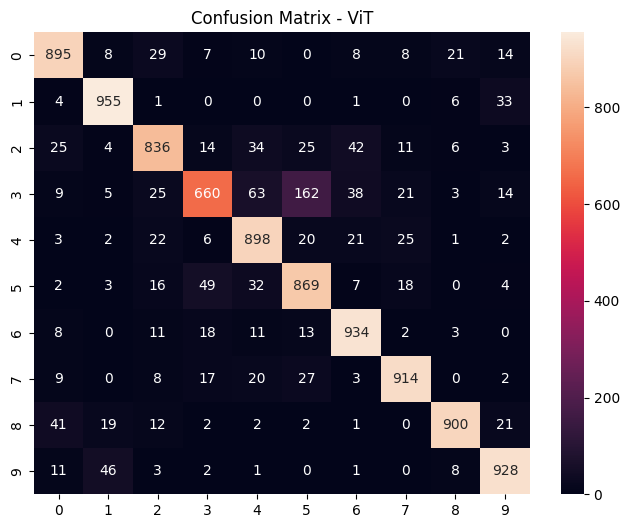

Inference: 0.8624559997007963 ms/img


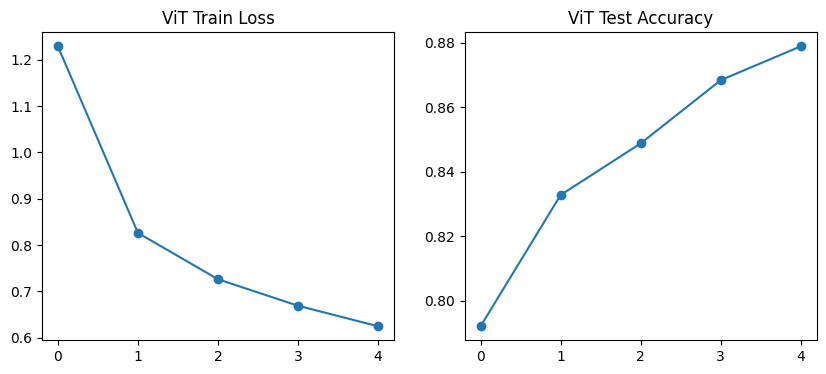

In [ ]:
print("=== TRAINING ViT ===")

model_vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=10)
model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_vit.parameters(), lr=LR)

total, trainable, non_trainable = count_params(model_vit)
size_mb = model_size_mb(model_vit)
print("Params:", total, " Size MB:", size_mb)

history_vit = {"train_loss": [], "test_acc": []}

for epoch in range(EPOCHS):
    loss = train_one_epoch(model_vit, train_loader_vit, optimizer, criterion)
    acc = evaluate_full(model_vit, test_loader_vit)

    history_vit["train_loss"].append(loss)
    history_vit["test_acc"].append(acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss={loss:.4f} | Acc={acc:.4f}")

torch.save(model_vit.state_dict(), "vit_cifar10.pth")
print("Saved vit_cifar10.pth")

acc, y_true, y_pred = evaluate_full(model_vit, test_loader_vit, return_preds=True)
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - ViT")
plt.show()

avg, std, th = measure_inference_time(model_vit, test_loader_vit)
print("Inference:", avg, "ms/img")

plot_history(history_vit, "ViT")


=== TRAINING SWIN TINY ===
Params: 27527044  Size MB: 110.176075


  0%|          | 0/6250 [00:00<?, ?it/s]/tmp/ipython-input-3698819440.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5 | Loss=0.7165 | Acc=0.9237


Epoch 2/5 | Loss=0.5648 | Acc=0.9297


Epoch 3/5 | Loss=0.5129 | Acc=0.9321


Epoch 4/5 | Loss=0.4926 | Acc=0.9257


Epoch 5/5 | Loss=0.4637 | Acc=0.9383
Saved swin_tiny_cifar10.pth
              precision    recall  f1-score   support

           0     0.9685    0.9220    0.9447      1000
           1     0.9597    0.9760    0.9678      1000
           2     0.9423    0.9140    0.9279      1000
           3     0.8627    0.8860    0.8742      1000
           4     0.9535    0.9430    0.9482      1000
           5     0.8812    0.9200    0.9002      1000
           6     0.9820    0.9260    0.9532      1000
           7     0.9648    0.9590    0.9619      1000
           8     0.9302    0.9730    0.9511      1000
           9     0.9470    0.9640    0.9554      1000

    accuracy                         0.9383     10000
   macro avg     0.9392    0.9383    0.9385     10000
weighted avg     0.9392    0.9383    0.9385     10000



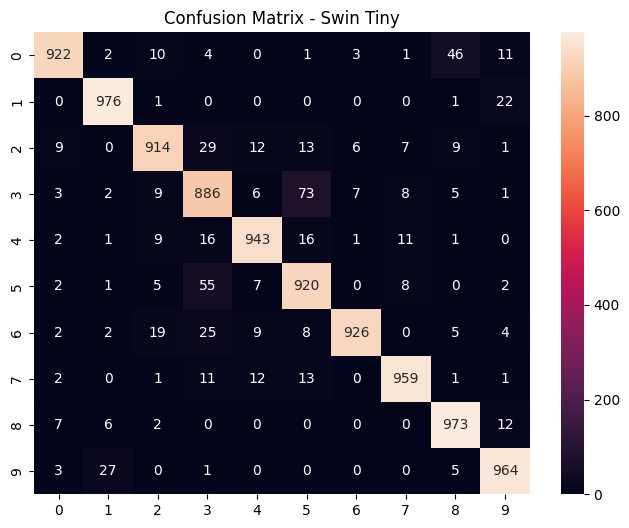

Inference: 2.0438263176987674 ms/img


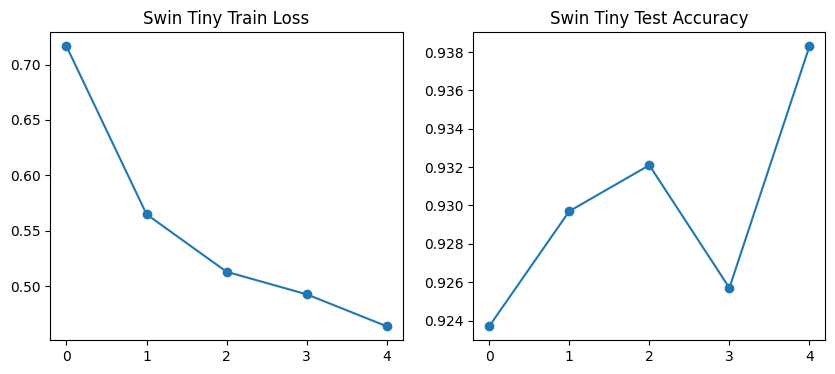

In [ ]:
print("=== TRAINING SWIN TINY ===")

model_swin = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=10)
model_swin.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_swin.parameters(), lr=LR)

total_s, trainable_s, non_trainable_s = count_params(model_swin)
size_mb_s = model_size_mb(model_swin)
print("Params:", total_s, " Size MB:", size_mb_s)

history_swin = {"train_loss": [], "test_acc": []}

for epoch in range(EPOCHS):
    loss = train_one_epoch(model_swin, train_loader_swin, optimizer, criterion)
    acc = evaluate_full(model_swin, test_loader_swin)

    history_swin["train_loss"].append(loss)
    history_swin["test_acc"].append(acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss={loss:.4f} | Acc={acc:.4f}")

torch.save(model_swin.state_dict(), "swin_tiny_cifar10.pth")
print("Saved swin_tiny_cifar10.pth")

acc, y_true, y_pred = evaluate_full(model_swin, test_loader_swin, return_preds=True)
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - Swin Tiny")
plt.show()

avg, std, th = measure_inference_time(model_swin, test_loader_swin)
print("Inference:", avg, "ms/img")

plot_history(history_swin, "Swin Tiny")
